In [1]:
%matplotlib widget
%load_ext autoreload
import numpy as np
import matplotlib
matplotlib.rcParams.update({ "pgf.texsystem": "pdflatex", 'font.family': 'serif', 'pgf.rcfonts': False,
                            "savefig.transparent" : True,  "svg.fonttype": 'none',  })
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=
       r'\usepackage{amsmath}'
       )
import matplotlib.figure, matplotlib.axes
import sys
import numpy as np
import pickle as pkl
import tqdm
import collections.abc
import torch
from utils import PredictionResults, color
import os
import matplotlib.transforms
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
import matplotlib.figure
from matplotlib.gridspec import GridSpec
from scipy.spatial.transform import Rotation

deepracing_path = os.environ["DEEPRACING_PATH"]
deepracingmodelsdir = os.path.abspath(os.path.join(deepracing_path, "DCNN-Pytorch"))
deepracingdir = os.path.abspath(os.path.join(deepracing_path, "deepracing_py"))
if (not (deepracingmodelsdir in sys.path)) or (not (deepracingdir in sys.path)):
    sys.path = [deepracingmodelsdir, deepracingdir] + sys.path
homedir = os.environ["HOME"]
mtrdir=os.path.join(homedir, "deepracingws", "MTR")
if (not (mtrdir in sys.path)):
    sys.path.insert(0, mtrdir)
print(os.getenv("PYTHONPATH"))
from utils import scatter_composite_axes, scatter_composite_xy

/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch:/l/ttw2xk/deepracingws/src/deepracing/deepracing_py:/l/ttw2xk/python3venvs/deepracing310/lib/python3.10/site-packages:


In [2]:

from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils
import torch.utils.data as torchdata
import yaml 
keys : set = {
    "hist",
    "hist_tangents",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_quats",
    "fut_vel",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "thistory",
    "tfuture"
}
with open("config.yaml", "r") as f:
    configdict : dict = yaml.safe_load(f)
realdata : bool = configdict["realdata"]
data_dir = "/p/DeepRacing/unpacked_datasets/iac_data_v3/deepracing_standard" if realdata \
           else "/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard"
mtr_data_dir = os.path.join(os.path.dirname(data_dir), "mtr_format", "1second")
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files(data_dir,
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)

if realdata:
    bezier_experiment = "registered_ottoman_7483"
    bezier_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/bezier_mixnet", bezier_experiment)
    composite_experiment = "musical_raccoon_7407" #encouraging_corolla_2210 musical_raccoon_7407
    composite_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/barte", composite_experiment)
    mixnet_experiment = "symbolic_varnish_9248"
    mixnet_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mixnet", mixnet_experiment)
    mtr_experiment = "worldwide_perch_1278"
    mtr_results_dir =  os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mtr", mtr_experiment)
else:
    bezier_experiment = "widespread_beans_6059"
    bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
    composite_experiment = "chosen_preservative_7505"
    composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
    mixnet_experiment = "agricultural_flue_8932"
    mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
    mtr_experiment = "formal_pedestal_9890"
    mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results/sim_data", mtr_experiment, "test_plots")


bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BézierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "BARTé")
composite_results.compute_fde()
composite_curves = torch.as_tensor(composite_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
# if not realdata:
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
composite_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "data.npz"), "MTR")
mtr_results["predictions_all"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(mtr_results["predictions_all"][:,0])
for idx in range(mtr_results["predictions_all"].shape[0]):
    mtr_results["predictions"][idx] = mtr_results["predictions_all"][idx,mtr_results["best_curve_idx"][idx]]
mtr_results.compute_fde()
# for k in ["history", "ground_truth"]

all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, composite_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))


all_results_composite_ref = [composite_results, mtr_results, bezier_results, mixnet_results]
all_results_mtr_ref = [mtr_results, composite_results, bezier_results, mixnet_results]

Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_0/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_1/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_2/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_3/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_4/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_5/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepr

In [3]:
# whis=None
# pf=98.0
metric="ade"
cross_error_kwargs = {
    "metric" : metric,
    "pf" : 98.0
}
if realdata:
    results_base = "/p/DeepRacing/trajectory_prediction_results/plots/real_data"
else:
    results_base = "/p/DeepRacing/trajectory_prediction_results/plots/sim_data"
os.makedirs(results_base, exist_ok=True)

idx_velplot = 72289
Building linear system
Solving linear system
Building linear system
Solving linear system
torch.Size([3, 5, 2])
10


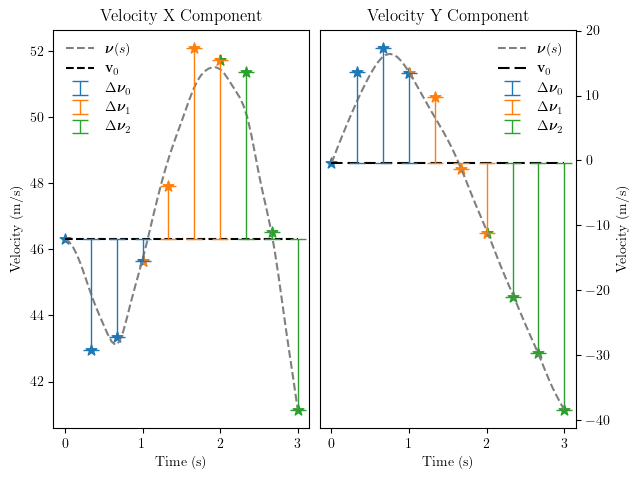

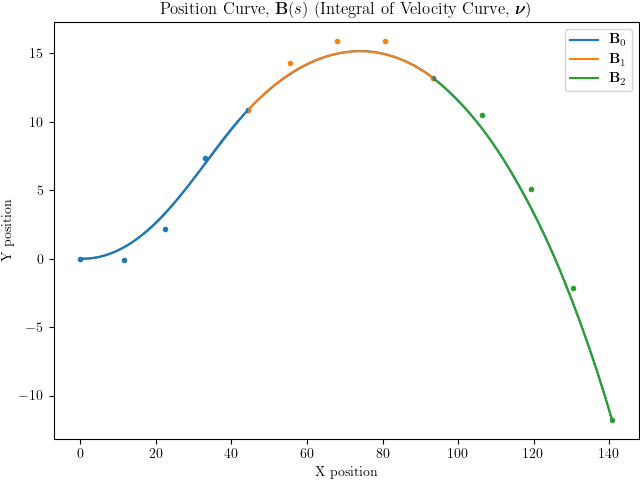

In [4]:

%autoreload 2
from utils import scatter_composite_axes, scatter_composite_xy
import matplotlib.transforms
import torch
from scipy.interpolate import BSpline, make_interp_spline
import deepracing_models.math_utils as mu
from matplotlib.markers import MarkerStyle
import matplotlib.axes
from matplotlib.axes import Axes
# idx_velplot = int(np.random.randint(0, high=len(fulldset), dtype=np.int64, size=(1,))[0])
# idx_velplot = 70836
# idx_velplot = 6196
# idx_velplot = 44916
# idx_velplot = 29441
# idx_velplot = 33974
# idx_velplot = 22451
# idx_velplot = 51389
# idx_velplot = 32508
# idx_velplot = 62948
idx_velplot = 72289
print( "idx_velplot = %d" % (idx_velplot,))
sample_velplot = fulldset[idx_velplot]
mask = np.ones_like(sample_velplot["fut"])
mask[:,2] = 0.0
Rmat  = Rotation.from_rotvec([0.0, 0.0, 0.0], degrees=True)
thistory : torch.Tensor = torch.as_tensor(sample_velplot["thistory"].copy(), dtype=torch.float64)
tfuture : torch.Tensor = torch.as_tensor(sample_velplot["tfuture"].copy(), dtype=thistory.dtype)
t0 = tfuture[0]
thistory = thistory - t0
tfuture = tfuture - t0
hist_vel : torch.Tensor = torch.as_tensor(Rmat.apply(sample_velplot["hist_vel"]*mask)[:,[0,1]], dtype=thistory.dtype)
fut_vel : torch.Tensor = torch.as_tensor(Rmat.apply(sample_velplot["fut_vel"]*mask)[:,[0,1]], dtype=thistory.dtype)
fut : torch.Tensor = torch.as_tensor(Rmat.apply(sample_velplot["fut"]*mask)[:,[0,1]], dtype=thistory.dtype)
gtvel_spline : BSpline = make_interp_spline(
    np.concatenate([thistory[:-1].cpu().numpy(), tfuture.cpu().numpy()]), 
    np.concatenate([hist_vel[:-1].cpu().numpy(), fut_vel.cpu().numpy()]), 
    k=3, bc_type="not-a-knot")
fut_speed = torch.norm(fut_vel, p=2.0, dim=1)
with_speed = False
try:
    plt.close("all")
except:
    pass
fig_vels, _axlist_ = plt.subplots(nrows=1, ncols=2 + int(with_speed))
axlist : list[Axes] = _axlist_
ax_velx = axlist[0]
ax_vely = axlist[1]
ax_speed = axlist[2] if with_speed else None

gt_artist, = ax_velx.plot(tfuture, fut_vel[:,0], label=r"$\boldsymbol{\nu}(s)$", color="grey", linestyle="--")
ax_vely.plot(tfuture, fut_vel[:,1], label=gt_artist.get_label(), color=gt_artist.get_color(), linestyle=gt_artist.get_linestyle())
if ax_speed is not None:
    ax_speed.plot(tfuture, fut_speed)

barte_curve : np.ndarray = composite_results["curves"][idx_velplot]
nsegments = barte_curve.shape[0]
kbezier = barte_curve.shape[1] - 1
dt = float(tfuture[-1]/nsegments)
dtvec = dt*torch.ones(nsegments, dtype=tfuture.dtype)

numsegments = 3
kbezier = 3
barte_pos_curve, tswitch = mu.compositeBezierFit(tfuture, fut, numsegments=numsegments, kbezier=kbezier+1, dYdT_0=fut_vel[0], dYdT_f=fut_vel[-1])
barte_vel_curve, tswitch = mu.compositeBezierFit(tfuture, fut_vel, numsegments=numsegments, kbezier=kbezier)


idxskip = None
# barte_vel_curve = torch.as_tensor((float(kbezier)/dt)*(barte_curve[:,1:]-barte_curve[:,:-1]), dtype=torch.float64)
# idxskip = 6

tscatter : torch.Tensor = torch.cat(
    [ torch.linspace(tswitch[i], tswitch[i+1], steps=kbezier+1, dtype=tswitch.dtype)[1:] for i in range(tswitch.shape[0]-1) ],
    dim = 0
)
tscatter = torch.cat([tswitch[[0,]], tscatter], dim=0)
velcurve_x_plot = torch.cat([fut_vel[0,0].unsqueeze(0), barte_vel_curve[:,1:,0].reshape(-1)], dim=0)
velcurve_y_plot = torch.cat([fut_vel[0,1].unsqueeze(0), barte_vel_curve[:,1:,1].reshape(-1)], dim=0)
velplot_colors = scatter_composite_axes(barte_vel_curve, tswitch, [ax_velx, ax_vely], marker="*", **{"s": 8**2})

v0 = fut_vel[0].clone()
v0x = v0[0].item()
v0hline = ax_velx.hlines(v0x, 
                tswitch[0].item(),
                tswitch[-1].item(),
                color="black", linestyle="--", label="$\\mathbf{v}_{0}$")
v0y = v0[1].item()
ax_vely.hlines(v0y, 
            tswitch[0].item(),
            tswitch[-1].item(),
            color=v0hline.get_color(), linestyle=v0hline.get_linestyle(), label="$\\mathbf{v}_{0}$")
for i in range(numsegments):
    segment = barte_vel_curve[i,1:]
    deltas = torch.abs(segment - v0)
    midpoints = (segment + v0)/2.0
    tslice = torch.linspace(tswitch[i], tswitch[i+1], steps=kbezier+1)[1:].cpu()   
    ax_velx.errorbar(tslice, midpoints[:,0], deltas[:,0]/2, fmt='', linewidth=1, capsize=6, linestyle='', color=velplot_colors[i], label=r"$\Delta{\boldsymbol{\nu}}_" + str(i) + "$")
    ax_vely.errorbar(tslice, midpoints[:,1], deltas[:,1]/2, fmt='', linewidth=1, capsize=6, linestyle='', color=velplot_colors[i], label=r"$\Delta{\boldsymbol{\nu}}_" + str(i) + "$")
   
ax_velx.legend(frameon=False, fancybox=False,)
ax_vely.legend(frameon=False, fancybox=False,)
ax_velx.set_title("Velocity X Component")
ax_velx.set_xlabel("Time (s)")
ax_velx.set_ylabel("Velocity (m/s)")
ax_vely.set_title("Velocity Y Component")
ax_vely.set_xlabel("Time (s)")
ax_vely.set_ylabel("Velocity (m/s)")
ax_vely.yaxis.tick_right()
ax_vely.yaxis.set_label_position("right")
fig_vels.tight_layout(pad=0.75)

print(barte_pos_curve.shape)
print(len(velplot_colors))
fig_pos, ax_pos = plt.subplots()
# ax_pos.scatter(barte_pos_curve[:,:,0].view(-1), barte_pos_curve[:,:,1].view(-1))
ax_pos.plot(fut[:,0], fut[:,1])
kwargs = {"s" : 3**2,  "colors" : velplot_colors,
          "tplot" : torch.linspace(tswitch[0].item(), tswitch[-1].item(), steps=120, device=tswitch.device, dtype=tswitch.dtype),
          "tswitch" : tswitch,
          "tannotate" : torch.as_tensor([1.6417], device=tswitch.device, dtype=tswitch.dtype)
          }
scatter_composite_xy(barte_pos_curve, ax_pos, **kwargs)
ax_pos.set_xlabel("X position")
ax_pos.set_ylabel("Y position")
ax_pos.legend()
ax_pos.set_title("Position Curve, $\\mathbf{B}(s)$ (Integral of Velocity Curve, $\\boldsymbol{\\nu}$)")
fig_pos.tight_layout(pad=0.1)

In [ ]:

mask = np.ones_like(fulldset[0]["future_left_bd"])
mask[:,2] = 0.0

rotation = Rotation.from_rotvec([0.0, 0.0, 0.5*np.pi])
grid_size = (2, 3)
num_plots = grid_size[0]*grid_size[1]
axes_lists : list[list[matplotlib.artist.Artist]] = []
fig_grid, _axs_ = plt.subplots(grid_size[0], grid_size[1])#, height_ratios=[1, 1, 2]), figsize=(7, 7)
axs : list[matplotlib.axes.Axes] = _axs_.flat
if realdata:
    random_samples = np.asarray([1948, 8261, 4934, 9637, 6114, 522], dtype=np.int64) # (2,3) grid, real data
else:
    random_samples = np.asarray([113918, 69634, 49583, 57128, 51780, 93685], dtype=np.int64) # (2,3) grid, sim data
#     random_samples = np.asarray([8387, 9498, 82174, 117623, 9113, 69920], dtype=np.int64) # (2,3) grid, sim data
# random_samples = np.random.randint(0, high=len(fulldset), size=(num_plots,))
# 
print(random_samples.tolist())
for i in range(random_samples.shape[0]):
    sample = fulldset[random_samples[i]]
    future_left_bd = rotation.apply(sample["future_left_bd"]*mask)[:,[0,1]]
    future_right_bd = rotation.apply(sample["future_right_bd"]*mask)[:,[0,1]]
    history = rotation.apply(sample["hist"]*mask)[:,[0,1]]
    ground_truth = rotation.apply(sample["fut"]*mask)[:,[0,1]]
    all_points = np.concatenate([future_left_bd, future_right_bd, ground_truth], axis=0)
    # ax : matplotlib.axes.Axes = fig_grid.add_subplot(gs[row, column])
    ax = axs[i]
    lbartists, = ax.plot(future_left_bd[:,0], future_left_bd[:,1], linestyle="solid", color="black", label="Track Boundaries")
    rbartists, = ax.plot(future_right_bd[:,0], future_right_bd[:,1], linestyle=lbartists.get_linestyle(), color=lbartists.get_color())
    # historyartists, = ax.plot(history[:,0], history[:,1], linestyle="--", color="black", label="History") , historyartists, history
    # gtartists, = ax.plot(ground_truth[:,0], ground_truth[:,1], label="Ground Truth")
    gtartists = ax.scatter(ground_truth[:,0], ground_truth[:,1], color="grey", label="Ground Truth", s=2.0**3.0)
    
    axes_lists.append([lbartists, rbartists, gtartists])
    for results in all_results_composite_ref:
        predictions_2d = results["predictions"][random_samples[i]][:,[0,1]].copy()
        predictions_3d = np.concatenate([predictions_2d, np.zeros_like(predictions_2d[:,[0,]])], axis=1)
        predictions = rotation.apply(predictions_3d)[:,[0,1]]
        predictionartist, = ax.plot(predictions[:,0], predictions[:,1], label=results.modelname)
        axes_lists[-1].append(predictionartist)
        all_points = np.concatenate([all_points, predictions], axis=0)
    min_x, max_x = np.min(all_points[:,0]) - 1.0, np.max(all_points[:,0]) + 1.0
    min_y, max_y = np.min(all_points[:,1]) - 1.0, np.max(all_points[:,1]) + 1.0
    ax.set_xlim(min_x, max_x)
    ax.set_xticks([])
    ax.set_ylim(min_y, max_y)
    ax.set_yticks([])
    aspect_ratio = 1.0125 * (max_x - min_x) / (max_y - min_y)
    # ax.set_axis_off()
    for pos in ['right', 'top', 'bottom', 'left']:
        ax.spines[pos].set_visible(False)
    # ax.set_aspect(aspect_ratio, "datalim")
    # ax.axis("equal")
    # if i==0:
    #     ax.legend(frameon=False)

fig_grid.subplots_adjust(wspace=0.05, hspace=0.05)
# fig_grid.tight_layout(h_pad=0.0, w_pad=0.0)

# metadata={"dataset" : "real" if realdata else "sim", "indices" : random_samples.tolist(), "data_dir" : data_dir}
metadata : dict = {k : None for k in ['Creator', 'Date', 'Format', 'Type']}
metadata["Creator"] = "Trent Weiss"
# metadata["Keywords"] = ["real" if realdata else "sim",] + [str(i) for i in random_samples]
# metadata["Source"] = data_dir
outfile = os.path.join(results_base, "examples_%s.svg" % ("real" if realdata else "sim",))
fig_grid.savefig(outfile, edgecolor=fig_grid.get_edgecolor(), bbox_inches="tight", transparent=True, metadata=metadata)
with open(outfile, "a") as f:
    f.write("<!-- %s: %s -->\n" % ("real" if realdata else "sim", str(random_samples)))
fig_grid.set_frameon(True)
fig_legend, _ax_legend_ = plt.subplots()
ax_legend : matplotlib.axes.Axes = _ax_legend_
ax_legend.set_axis_off()
legend = ax_legend.legend(
    *(axs[0].get_legend_handles_labels()),
    loc="lower left", 
    bbox_to_anchor=(0, 0),
    frameon=False,
    fancybox=False,
    ncols=3
)
bbox = legend.get_window_extent().transformed(fig_legend.dpi_scale_trans.inverted())
fig_legend.savefig(os.path.join(results_base, "examples_legend.svg"), bbox_inches=bbox, dpi="figure", transparent=True, metadata=metadata)
plt.close(fig=fig_legend)
# plt.close(fig=fig_grid)
#113918, 69634, 49583, 57128, 51780, 93685 sim
# 1948, 8261, 4934, 9637, 6114, 522  real

In [ ]:


import shutil

rcparams_latex = {
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
}

plots_dir = os.path.join(results_base, "plots")
histograms_dir = os.path.join(results_base, "histograms")
plots_dir_trimmed = os.path.join(results_base, "plots_trimmed")
histograms_dir_trimmed = os.path.join(results_base, "histograms_trimmed")

In [ ]:
from utils import create_table
from texttable import Texttable

results_textable = create_table([composite_results, mtr_results, mixnet_results, bezier_results])
results_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_textable.draw())
# results_trimmed_textable = create_table([composite_results_trimmed, mtr_results_trimmed, mixnet_results_trimmed, bezier_results_trimmed])
# results_trimmed_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
# print(results_trimmed_textable.draw())

In [ ]:

maindir = os.path.join(results_base, "cross_error_analysis")
basedir = os.path.join(maindir, metric)
os.makedirs(basedir, exist_ok=True)
barchart_dir =  os.path.join(results_base, "bar_charts", metric)
os.makedirs(barchart_dir, exist_ok=True)


In [ ]:

total_samples = composite_results[metric].shape[0]

barte_nonoutliers, barte_maxval = composite_results.trim_percentiles(**{k : cross_error_kwargs[k] for k in {"metric", "pf"}})
mtr_nonoutliers, mtr_maxval = mtr_results.trim_percentiles(**{k : cross_error_kwargs[k] for k in {"metric", "pf"}})


# mtr_nonoutliers, mtr_maxval = mtr_results.trim_iqr(metric=metric, whis=whis)
# barte_nonoutliers, barte_maxval = composite_results.trim_iqr(metric=metric, whis=whis)


In [ ]:

%autoreload 2
from utils import plot_outlier_counts
bar_kw = dict(
    color = "black",
    alpha = .8,
    width = .4,
    log=True
)
bar_label_kw = dict(
    padding = 1
)
figbar, axbar = plot_outlier_counts(all_results_composite_ref, metric, mtr_maxval, bar_kw=bar_kw, bar_label_kw=bar_label_kw)
axbar.set_title("Outlier Counts for 98th percentile of %s's ADE Values" % (mtr_results.modelname))
figbar2, axbar2 = plot_outlier_counts(all_results_composite_ref, metric, barte_maxval, bar_kw=bar_kw, bar_label_kw=bar_label_kw)
axbar2.set_title("Outlier Counts for 98th percentile of %s's ADE Values" % (composite_results.modelname))
with plt.rc_context({ "pgf.texsystem": "pdflatex", 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False,
                        "savefig.bbox" : "tight", "savefig.orientation" : "landscape",
                        "savefig.transparent" : True, "savefig.pad_inches" : 0.05, "svg.fonttype": 'none', 
                    }) as ctx:
    figbar.savefig(os.path.join(barchart_dir, "outlier_counts_mtr_maxval.svg"))
    figbar.savefig(os.path.join(barchart_dir, "outlier_counts_mtr_maxval.pgf"))

    figbar2.savefig(os.path.join(barchart_dir, "outlier_counts_barte_maxval.svg"))
    figbar2.savefig(os.path.join(barchart_dir, "outlier_counts_barte_maxval.pgf"))
# plt.show()

In [ ]:
%autoreload 2
from utils import cross_error_analysis
print([res.modelname for res in all_results_composite_ref])
box_plot_maxes = 1.015*float(np.percentile(mixnet_results[metric], cross_error_kwargs["pf"]))
scale_ticks = np.linspace(0.02, box_plot_maxes, num=6).tolist() +\
            [
                0.5*(float(mixnet_results[metric].max()) + box_plot_maxes),
                1.025*float(mixnet_results[metric].max()),
            ]
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_composite_ref, fulldset, basedir,
                     pf=None, whis=None, metric=metric, box_plot_scale="linear", vertlines=True,
                     box_plot_maxes=box_plot_maxes, scale_ticks=np.asarray(scale_ticks), individual_plots=False)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
# plt.show()
# cross_error_analysis(all_results_mtr_ref, fulldset, basedir, pf=None, whis=None, metric=metric, histograms=False)

In [ ]:

%autoreload 2
from utils import cross_error_analysis
barte_inliers = composite_results[metric]<=mtr_maxval
mtr_inliers = mtr_results[metric]<=mtr_maxval
both_good = mtr_inliers*barte_inliers
box_plot_maxes = {res.modelname : 1.05*float(np.percentile(res[metric][both_good], cross_error_kwargs["pf"])) for res in [mtr_results, composite_results]}
box_plot_maxes[composite_results.modelname] = box_plot_maxes[mtr_results.modelname]
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     subdir="both_models_good_mtr_maxval", idx_filter=both_good, scale_ticks = np.linspace(0.0, 1.025*mtr_maxval, num=10),
                     pf=None, whis=None, metric=metric, vertlines=True, showfliers=False)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


In [ ]:

%autoreload 2
from utils import cross_error_analysis
all_good = np.ones_like(mtr_results[metric], dtype=bool)
for res in all_results_composite_ref:
    current_good = res[metric]<=mtr_maxval
    all_good*=current_good
box_plot_maxes = {res.modelname : 1.05*float(np.percentile(res[metric][all_good], cross_error_kwargs["pf"])) for res in [mtr_results, composite_results]}
box_plot_maxes[composite_results.modelname] = box_plot_maxes[mtr_results.modelname]
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     subdir="all_models_good_barte_mtr_only_mtr_maxval", idx_filter=all_good,
                    pf=None, whis=None, metric=metric, vertlines=True, 
                    box_plot_maxes = box_plot_maxes)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


In [ ]:

%autoreload 2
from utils import cross_error_analysis
all_good = np.ones_like(mtr_results[metric], dtype=bool)
for res in all_results_composite_ref:
    current_good = res[metric]<=mtr_maxval
    print("%s has %d outliers" % (res.modelname, int(np.sum(~current_good))))
    all_good*=current_good

box_plot_maxes = {res.modelname : 1.05*float(np.percentile(res[metric][all_good], cross_error_kwargs["pf"])) for res in all_results_composite_ref}
box_plot_maxes[composite_results.modelname] = box_plot_maxes[mtr_results.modelname]

(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_composite_ref, fulldset, basedir, 
                     subdir="all_models_good_mtr_maxval", idx_filter=all_good,
                    pf=None, whis=None, metric=metric, vertlines=True, 
                    box_plot_maxes = box_plot_maxes, scale_ticks = np.linspace(0.0, 1.025*mtr_maxval, num=10))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


In [ ]:

%autoreload 2
from utils import cross_error_analysis

barte_inliers = composite_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=mtr_maxval
both_good = barte_inliers*mtr_inliers

(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric, subdir = "both_models_good_merged", idx_filter = both_good, 
                     scale_ticks = np.linspace(0.0, 1.025*mtr_maxval, num=10))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
# cross_error_analysis([barte_both_good, mtr_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric, histograms=False)

In [ ]:

%autoreload 2
from utils import cross_error_analysis

barte_inliers = composite_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=barte_maxval
both_good = barte_inliers*mtr_inliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric, vertlines=True, showfliers=False,
                       subdir = "both_models_good_barte_maxval", idx_filter = both_good,
                       scale_ticks = np.linspace(0.0, 1.025*barte_maxval, num=10))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
# cross_error_analysis([barte_both_good, mtr_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric, histograms=False)

In [ ]:
%autoreload 2
from utils import cross_error_analysis
histogram_ticks : list[float] = np.linspace(0.02, 2.33, num=4).tolist()
histogram_ticks.append(10.35)
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric, vertlines=True, histogram_ticks=np.asarray(histogram_ticks),
                       subdir = "baseline_only_barte_mtr", idx_filter = np.ones_like(mtr_results[metric], dtype=bool))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)

In [ ]:
%autoreload 2
from utils import cross_error_analysis
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_composite_ref, fulldset, basedir, other_models=[mtr_results.modelname,], **cross_error_kwargs)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_mtr_ref, fulldset, basedir, other_models=[composite_results.modelname,], **cross_error_kwargs)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)

In [ ]:
%autoreload 2
from utils import cross_error_analysis
barte_outliers = composite_results[metric]>barte_maxval
mtr_outliers = mtr_results[metric]>mtr_maxval
both_bad = barte_outliers*mtr_outliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric,  vertlines=True, scale_ticks="linear",
                       subdir = "both_models_bad_merged", idx_filter = both_bad)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


In [ ]:
%autoreload 2
from utils import cross_error_analysis
# plt.close("all")


barte_outliers = composite_results[metric]>barte_maxval
mtr_outliers = mtr_results[metric]>barte_maxval
both_bad = barte_outliers*mtr_outliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric,  vertlines=True, scale_ticks="linear",
                       subdir = "both_models_bad_barte_maxval", idx_filter = both_bad)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


In [ ]:

# plt.close("all")
barte_outliers = composite_results[metric]>mtr_maxval
mtr_outliers = mtr_results[metric]>mtr_maxval
both_bad = barte_outliers*mtr_outliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric,  vertlines=True, scale_ticks="linear",
                       subdir = "both_models_bad_mtr_maxval", idx_filter = both_bad)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)

In [ ]:


# idx_good = plot_outliers([composite_results, mtr_results, mixnet_results, bezier_results], plots_dir, fulldset, N=25, metric_key="ade", worst=False)




# sample = fulldset[idx_good[26]]
import matplotlib.transforms
from scipy.spatial.transform import Rotation
from matplotlib.collections import LineCollection, Collection
from matplotlib.colors import BoundaryNorm, ListedColormap, Colormap
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.patches import ArrowStyle
import matplotlib.cm
import matplotlib.colorbar as cb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.axes, matplotlib.figure
import copy
class HandlerColorLineCollection(HandlerLineCollection):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        x = np.linspace(0,width,self.get_numpoints(legend)+1)
        y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=artist.cmap,
                     transform=trans, linestyle=artist.get_linestyle())
        lc.set_array(x)
        lc.set_linewidth(artist.get_linewidth())
        return [lc]
def add_colored_line(points : np.ndarray, cvals : np.ndarray, ax : matplotlib.axes.Axes, cmap : str | Colormap, 
    linestyle="solid", alpha=1.0) -> tuple[LineCollection, Collection]:
    points_exp = points.reshape(-1, 1, points.shape[-1])
    segments = np.concatenate([points_exp[:-1], points_exp[1:]], axis=1)
    norm = plt.Normalize(cvals.min(), cvals.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm,linestyle=linestyle, alpha=alpha)
    
    lc.set_array(cvals)
    line = ax.add_collection(lc)
    return lc, line
# mtr_outliers = ~mtr_nonoutliers
# mtr_outliers_idx = np.where(mtr_outliers)[0]
mtr_argsort = np.flipud(np.argsort(mtr_results["ade"]))
# idx_rand = np.random.choice(mtr_outliers_idx)
idx_rand = mtr_argsort[7]
sample = fulldset[idx_rand]
print(idx_rand)
print(sample.keys())

Rmat = Rotation.from_rotvec([0.0, 0.0, 0.5*np.pi]).as_matrix()[0:2,0:2]
history_start = 0
history = (Rmat @ sample["hist"][history_start:,[0,1]].T).T
history_vels = (Rmat @ sample["hist_vel"][history_start:,[0,1]].T).T
history_speeds = np.linalg.norm(history_vels, ord=2.0, axis=1)
history_tangents = (Rmat @ sample["hist_tangents"][history_start:,[0,1]].T).T
#history_vels/history_speeds[:,None]

history_all_vels = (Rmat @ sample["hist_vel"][:,[0,1]].T).T
history_all_speeds = np.linalg.norm(history_all_vels, ord=2.0, axis=1)


ground_truth = (Rmat @ sample["fut"][:,[0,1]].T).T
ground_truth_vels = (Rmat @ sample["fut_vel"][:,[0,1]].T).T
ground_truth_speeds = np.linalg.norm(ground_truth_vels, ord=2.0, axis=1)

all_points = np.concatenate([history, ground_truth], axis=0)
all_speeds = np.concatenate([history_speeds, ground_truth_speeds], axis=0)




thistory = sample["thistory"]
tfuture = sample["tfuture"]
future_left_bd = (Rmat @ sample["future_left_bd"][:,[0,1]].T).T
future_right_bd = (Rmat @ sample["future_right_bd"][:,[0,1]].T).T
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
allpoints = np.concatenate([history, ground_truth], axis=0)
topleft = np.min(allpoints, axis=0) - 1.0
bottomright = np.max(allpoints, axis=0)# + 1.0
asdf : tuple[matplotlib.figure.Figure, list[matplotlib.axes.Axes]] = plt.subplots(1,2)
fig : matplotlib.figure.Figure = asdf[0]
ax : matplotlib.axes.Axes = asdf[1][0]
ax.set_xlim(topleft[0], bottomright[0])
ax.set_ylim(topleft[1], bottomright[1])
ax.plot(future_left_bd[:,0], future_left_bd[:,1], linestyle="solid", color="black")
boundaries = ax.plot(future_right_bd[:,0], future_right_bd[:,1], linestyle="solid", color="black")
norm = plt.Normalize(all_speeds.min(), all_speeds.max(), clip=True)
cmap = "RdYlGn"
scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
lc_hist, line_hist = add_colored_line(history, history_speeds[:-1], ax, cmap, linestyle="dotted")
lc_ground_truth, line_ground_truth  = add_colored_line(ground_truth, ground_truth_speeds[:-1], ax, cmap)
line_ground_truth.set_label("asdf")
lc_ground_truth.set_label("asdf")
# lc_fake, line_fake  = add_colored_line(all_points, all_speeds[:-1], ax, cmap, alpha=0.25)

# ax.plot(history[:,0], history[:,1], linestyle="--", color=history_speeds, cmap="viridis", norm=norm, alpha=0.5, label="History")
# ax.plot(ground_truth[:,0], ground_truth[:,1], linestyle="dotted", color="black", label="Ground Truth")
# ax.axis("equal")
axlegend = ax.legend([
               lc_hist, 
               lc_ground_truth,
               boundaries[0],
           ],
           [
               "History", 
               "Ground Truth", 
               "Boundaries",
           ], 
        #    loc=(0.1, 0.5),
          handler_map={
              lc_hist: HandlerColorLineCollection(numpoints=4),
              lc_ground_truth: HandlerColorLineCollection(numpoints=4),

            },
            frameon=False, fancybox=False)
for t in axlegend.get_texts():
    # t.set_ha('center')
    t.set_fontsize(10)
os.makedirs(plots_dir, exist_ok=True)
ax.set_xticks([])
ax.set_yticks([])


ax_speed = asdf[1][1]

ax_speed.plot(thistory, history_all_speeds, label="History", linestyle="--", color="grey")
ax_speed.plot(tfuture, ground_truth_speeds, label="Ground Truth", color="black")
ax_speed.axhline(ground_truth_speeds.min(), xmin=0.0, xmax=1.0, linestyle="--", color="black", alpha=0.8)
ax_speed.axhline(history_all_speeds.max(), xmin=0.0, xmax=1.0, linestyle="--", color="black", alpha=0.8)
ax_speed.legend(frameon=False, fancybox=False)

ihistmax = np.argmax(history_all_speeds)
t_max_speed = thistory[ihistmax]
max_speed = history_all_speeds[ihistmax]

igtmin = np.argmin(ground_truth_speeds)
t_min_speed = tfuture[igtmin]
min_speed = ground_truth_speeds[igtmin]
average_acceleration=float((min_speed - max_speed)/(t_min_speed - t_max_speed))
accel_sign = np.sign(average_acceleration)
print()
up = np.asarray([0.0, 1.0])
ptop = np.asarray([45.6, max_speed]) + 0.3*up
pbottom = np.asarray([ptop[0], min_speed]) - 0.3*up

pmiddle = 0.5*(pbottom + ptop)
bbox = dict(boxstyle="round", fc="0.8",)
arrowprops = dict(
    arrowstyle="->",
    )
textobject = ax_speed.text(0.81, 0.5, "Average of\n%.3fG of %s" % (np.abs(average_acceleration)/9.8, "acceleration" if accel_sign>0 else "braking"), 
                           horizontalalignment='center', verticalalignment='center', fontsize=10, transform=ax_speed.transAxes)
up_arrow = ax_speed.annotate("", ptop, annotation_clip=False,
                    # xytext=pmiddle + 0.5*up,  .inverted()
                    xytext=(0.5, 1.0), 
                    textcoords=textobject,
                    arrowprops=arrowprops)


ax_speed.annotate("", pbottom, annotation_clip=False,
                    # xytext=pmiddle - 0.5*up, 
                    xytext=(0.5, 0.0), 
                    textcoords=textobject, 
                    arrowprops=arrowprops)

ax.set_aspect(0.75, adjustable='datalim')
idx_angle = np.arange(0, history.shape[0], step=7, dtype=np.int64)
history_tangents_data = history_tangents[idx_angle].copy()
angles_data = np.arctan2(history_tangents_data[:,1], history_tangents_data[:,0])#*180.0/np.pi

# tf_plot = copy.deepcopy(ax.transAxes)

# tf_inverted = ax.transAxes + ax.transData.inverted()
tf_inverted = copy.deepcopy(fig.dpi_scale_trans) + ax.transData.inverted() 


tf_plot = tf_inverted  + ax.transData
tf = tf_inverted.inverted()

history_data = history[idx_angle].copy()
history_axis = tf.transform(history_data)

angles_axis = tf.transform_angles(angles_data, history_data, radians=True)
tangents_axis = np.stack([np.cos(angles_axis), np.sin(angles_axis)], axis=1)
# tangents_axis[:,0]*=-1.0
print(tangents_axis)

normal_angles_axis = angles_axis - np.pi/2
normals_axis = np.stack([np.cos(normal_angles_axis), np.sin(normal_angles_axis)], axis=1)

tangent_offset_points_axis = history_axis + .25*tangents_axis
normal_offset_points_axis = history_axis + .25*normals_axis
# arrowprops["transform"] = tf_plot
for i in range(history_axis.shape[0]):
    # ax.arrow(history_axis[i,0], history_axis[i,1], tangents_axis[i,0], tangents_axis[i,1], transform=tf_plot, width=0.01, length_includes_head=True)
    ax.annotate("", tangent_offset_points_axis[i],   xytext = history_data[i],
                    xycoords = tf_plot,              textcoords = "data", 
                    arrowprops=arrowprops)
    ax.annotate("", normal_offset_points_axis[i],    xytext = history_data[i],
                    xycoords = tf_plot,              textcoords = "data", 
                    arrowprops=arrowprops)


ax_speed.xaxis.tick_bottom()
# ax_speed.tick_params(axis="x", direction="in")
ax_speed.set_axisbelow(True)
fig.align_xlabels()
fig.tight_layout(pad=0.5)
colorbar : cb.Colorbar = fig.colorbar(scalar_mappable, ax=ax, location='left')
extent = ax.dataLim.transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(plots_dir, "label_onlyposition.svg"), bbox_inches=extent, pad_inches=0.02, transparent=True)
extent = ax_speed.get_tightbbox().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(plots_dir, "label_onlyspeed.svg"), bbox_inches=extent, pad_inches=0.02, transparent=True)
fig.savefig(os.path.join(plots_dir, "label.svg"), pad_inches=0.02, transparent=True)
plt.show()

In [ ]:
import os
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
plt.rcParams["text.usetex"]=True
results_list = all_results_mtr_ref
ref_results = results_list[0]
alpha_dict = {res.modelname : 0.5 for res in results_list}
alpha_dict[composite_results.modelname] = 1.0 
alpha_dict[mtr_results.modelname] = 1.0 

# idx_rand = np.random.randint(0, high=len(fulldset))
idx_rand = mtr_argsort[7]
sample = fulldset[idx_rand]
print(sample.keys())
# Rmat = np.eye(2, dtype=sample["hist"].dtype)
Rmat = Rotation.from_rotvec([0.0, 0.0, np.pi/2.0]).as_matrix()[0:2,0:2]
history = (Rmat @ sample["hist"][:,[0,1]].T).T
ground_truth = (Rmat @ sample["fut"][:,[0,1]].T).T
future_left_bd = (Rmat @ sample["future_left_bd"][:,[0,1]].T).T
future_right_bd = (Rmat @ sample["future_right_bd"][:,[0,1]].T).T

artist_dict : dict[str,matplotlib.lines.Line2D | matplotlib.collections.PathCollection] = dict()
fig, _axmain_ = plt.subplots()
axmain : matplotlib.axes.Axes = _axmain_
history_label = "History"
artist_dict[history_label] = axmain.plot(history[:,0], history[:,1], label=history_label, linestyle="--", c="grey")[0]
ground_truth_label = "Ground Truth"
artist_dict[ground_truth_label] = axmain.scatter(ground_truth[:,0], ground_truth[:,1], label=ground_truth_label, c="grey", alpha=0.5, s=10.0)
print(ref_results["predictions"][idx_rand].shape)
mtr_predictions = (Rmat @ ref_results["predictions"][idx_rand][:,[0,1]].T).T
axes_to_data = axmain.transAxes + axmain.transData.inverted()
data_to_axes = axes_to_data.inverted()

# start_point_axes = data_to_axes.transform(mtr_predictions[-int(round(.35*mtr_predictions.shape[0]))])
# start_point_axes[0] = 0.0
start_point_axes = data_to_axes.transform(future_left_bd[-int(round(.15*mtr_predictions.shape[0]))])
start_point = axes_to_data.transform(start_point_axes)

end_point_axes = data_to_axes.transform(mtr_predictions[-1])
end_point_axes[0] += 1E-2
end_point_axes[1] += 3E-2
end_point = axes_to_data.transform(end_point_axes)

p0 = start_point - 10.0
pf = end_point + 7.5
delta = pf - p0
predictions_dict : dict[str,np.ndarray] = dict()
predictions_dict[mtr_results.modelname] = mtr_predictions
predictions_dict["Ground Truth"] = ground_truth
predictions_inset_dict : dict[str,np.ndarray] = dict()
p0deltas = mtr_predictions - p0[None]
pfdeltas = -mtr_predictions + pf[None]
p0deltas = ground_truth - p0[None]
pfdeltas = -ground_truth + pf[None]
ground_truth_inset = ground_truth[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
for (idx, results) in enumerate(results_list):
    predictions = (Rmat @ results["predictions"][idx_rand][:,[0,1]].T).T
    artist_dict[results.modelname] = axmain.plot(predictions[:,0], predictions[:,1], label=results.modelname, alpha=alpha_dict[results.modelname])[0]
    predictions_dict[results.modelname] = predictions.copy()
    p0deltas = predictions - p0[None]
    pfdeltas = -predictions + pf[None]
    predictions_inset_dict[results.modelname] = predictions[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
barte_predictions = predictions_dict[composite_results.modelname]
mixnet_predictions = predictions_dict[mixnet_results.modelname]

predictions_inset_dict["left_bound"] = future_left_bd[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
predictions_inset_dict["right_bound"] = future_right_bd[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()

boundcolor="black"
left_bound_input = sample["left_bd"]
artist_dict["left_bound"] = axmain.plot(future_left_bd[:,0], future_left_bd[:,1], color=boundcolor, label="Track Bounds")[0]
right_bound_input = sample["right_bd"]
artist_dict["right_bound"] = axmain.plot(future_right_bd[:,0], future_right_bd[:,1], color=boundcolor)[0]
axmain.axis("equal")
#ground_truth[0] + 
fig.canvas.draw()
axes_to_data = axmain.transAxes + axmain.transData.inverted()
data_to_axes = axes_to_data.inverted()
inset_origin = future_right_bd[0] + np.asarray([35.0, -25.0], dtype=future_right_bd.dtype)
inset_origin_axes = data_to_axes.transform(inset_origin)
# inset_origin_axes = np.asarray([0.675, 0.4], dtype=ground_truth.dtype)
print(inset_origin)
print(inset_origin_axes)
axinset : matplotlib.axes.Axes = axmain.inset_axes(
    [
        inset_origin_axes[0], 
        inset_origin_axes[1], 
        0.25, 
        0.25
    ],
    xlim=(start_point[0], end_point[0]), ylim=(start_point[1], end_point[1]), xticklabels=[], yticklabels=[])
for (k, v) in predictions_inset_dict.items():
    mplobject = artist_dict[k]
    if type(mplobject) is matplotlib.collections.PathCollection:
        color = mplobject.get_facecolor()
    elif type(mplobject) is matplotlib.lines.Line2D:
        color = mplobject.get_color()
    else:
        raise ValueError("?")
    axinset.plot(v[:,0], v[:,1], label=k, color=color, alpha=mplobject.get_alpha())
axinset.scatter(ground_truth_inset[:,0], ground_truth_inset[:,1], label="Ground Truth", c="grey", alpha=1.0, s=10.0)
# theta = (np.pi/180.0)*37.5
# fontsize=10
# label_lines=["End of",
#             "ground-truth",
#             "trajectory"]
# label=""
# for line in label_lines:
#     label+=line
#     label+="\n"
# label = label.strip()
# gtend_annotation = axinset.annotate(label, 
#                         ground_truth_inset[-1], xycoords="data",
#                        xytext=90.0*np.asarray([-0.2, 1.0]), textcoords="axes points", fontsize=fontsize,
#                        arrowprops=dict(arrowstyle=ArrowStyle.CurveB()),
#                        annotation_clip=False, multialignment="center")
# label_lines=["MTR has large",
#             "longituindal error,",
#             "predicting the vehicle",
#             "will travel significantly",
#             "farther than the",
#             "ground-truth"]
# label=""
# for line in label_lines:
#     label+=line
#     label+="\n"
# label = label.strip()
# gtend_annotation = axinset.annotate(label, 
#                         mtr_predictions[-1], xycoords="data",
#                        xytext=105.0*np.asarray([0.5, -1.0]), textcoords="axes points", fontsize=fontsize,
#                        arrowprops=dict(arrowstyle=ArrowStyle.CurveB()),
#                        annotation_clip=False, multialignment="center")
axmain.indicate_inset_zoom(axinset, edgecolor="black")
axmain.get_xaxis().set_ticks([])
axmain.get_yaxis().set_ticks([])
for pos in ['right', 'top', 'bottom', 'left']: 
    axmain.spines[pos].set_visible(False) 
historymin = np.min(history[:,0])
historymax = np.max(history[:,0])
axmain.set_xlim(historymin, historymax + 2.0) #fancybox=False, 
axmain.legend(frameon=False, loc="upper left", bbox_to_anchor=[0.6,0.375])
fig.tight_layout(pad=0.1)
fig.savefig(os.path.join(plots_dir, "example_predictions.pgf"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "example_predictions.pdf"), pad_inches=0.02)
plt.show()

In [ ]:
import deepracing_models.math_utils
from matplotlib.markers import MarkerStyle

print(composite_results.keys())
device = torch.device("cpu")
dtype = torch.float64
predicted_curve = torch.as_tensor(composite_results["curves"][idx_rand], device=device, dtype=dtype)
predicted_curve = (torch.as_tensor(Rmat, device=device, dtype=dtype)[None, None] @ predicted_curve[...,None]).squeeze(-1)
tfuture_torch = torch.as_tensor(tfuture - tfuture[0], device=device, dtype=dtype)
tswitch = torch.linspace(0.0, tfuture_torch[-1], steps=predicted_curve.shape[0] + 1, device=device, dtype=dtype)
tstart = tswitch[:-1]
dt = tswitch[1:] - tstart
bezier_order = predicted_curve.shape[-2] - 1
predicted_vel_curve = bezier_order*(predicted_curve[:,1:] - predicted_curve[:,:-1])/dt[...,None,None]


tsamp_torch = torch.linspace(0.0, tfuture_torch[-1].item(), steps=25, dtype=dtype, device=device)

tsamp_torch_dense = torch.linspace(0.0, tfuture_torch[-1].item(), steps=600, dtype=dtype, device=device)
predicted_positions_dense, idx_buckets_dense = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_curve, tsamp_torch_dense)

predicted_vels, _ = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_vel_curve, tsamp_torch)

fig_positions, _ax_positions_ = plt.subplots()
ax_positions : matplotlib.axes.Axes = _ax_positions_
segments_colors = []
bool_idx = idx_buckets_dense==0
current_control_points = predicted_curve[0].cpu()
current_positions = predicted_positions_dense[bool_idx]
current_color = ax_positions.plot(current_positions[:,0], current_positions[:,1])[0].get_color()
ax_positions.scatter(current_control_points[:-1,0], current_control_points[:-1,1], c=current_color, label="Segment 0")
segments_colors.append(current_color)
for curve_idx in range(1, predicted_curve.shape[0]):
    bool_idx = idx_buckets_dense==curve_idx
    current_positions = predicted_positions_dense[bool_idx]
    current_color = ax_positions.plot(current_positions[:,0], current_positions[:,1])[0].get_color()
    segments_colors.append(current_color)
    label="Segment %d" % (curve_idx,)

    current_control_points = predicted_curve[curve_idx].cpu()
    ax_positions.scatter(current_control_points[1:-1,0], current_control_points[1:-1,1], c=current_color, label=label)
    ax_positions.scatter(current_control_points[0,0], current_control_points[0,1], c=current_color, edgecolor=None, marker=MarkerStyle("o", fillstyle="right"))
    ax_positions.scatter(current_control_points[0,0], current_control_points[0,1], c=segments_colors[-2], edgecolor=None, marker=MarkerStyle("o", fillstyle="left"))
ax_positions.scatter(predicted_curve[-1,-1,0], predicted_curve[-1,-1,1], c=segments_colors[-1])
ax_positions.legend()
# ax_positions.axis("equal")
# ax_positions.axis("equal")
predicted_positions, idx_buckets = deepracing_models.math_utils.compositeBezierEval(tstart, dt, predicted_curve, tsamp_torch)
fig_arrows, _ax_arrows_ = plt.subplots()
ax_arrows : matplotlib.axes.Axes = _ax_arrows_
skip=4
for curve_idx in range(predicted_curve.shape[0]):
    bool_idx = idx_buckets==curve_idx
    current_positions = predicted_positions[bool_idx]
    current_vels = predicted_vels[bool_idx]
    current_color = segments_colors[curve_idx]
    label="Segment %d" % (curve_idx,)
    ax_arrows.quiver(current_positions[:,0], current_positions[:,1], current_vels[:,0], current_vels[:,-1], angles="xy", color=current_color, label=label)
ax_arrows.legend()
# ax_arrows.axis("equal")
fig_positions.tight_layout(pad=0.1)
fig_positions.savefig(os.path.join(plots_dir, "positions.svg"), pad_inches=0.02)
fig_positions.savefig(os.path.join(plots_dir, "positions.png"), backend="agg", pad_inches=0.02)
fig_arrows.tight_layout(pad=0.1)
fig_arrows.savefig(os.path.join(plots_dir, "arrows.svg"), pad_inches=0.02)
fig_arrows.savefig(os.path.join(plots_dir, "arrows.png"), backend="agg", pad_inches=0.02)